# **Retrieval Augmented Generation (RAG) 애플리케이션 구축: Part 1**

### 자신만의 문서를 활용하여 응답을 생성하는 애플리케이션 구축

- **Part 1**: RAG 개념을 소개하고, 최소한의 구현 방법을 설명합니다.  
- **Part 2** 기존 구현을 확장하여 대화형 상호작용과 다단계 검색 프로세스를 처리할 수 있도록 개선합니다.
---

## 전형적인 **RAG 애플리케이션**

두 가지 주요 구성 요소로 이루어져 있습니다:  

1. **인덱싱(Indexing)**: 데이터 소스를 수집하고 인덱싱하는 파이프라인입니다. *일반적으로 오프라인에서 수행됩니다.*  
2. **검색 및 생성(Retrieval and Generation)**: 실행 시간에 사용자 쿼리를 받아 인덱스에서 관련 데이터를 검색한 후, 모델에 전달하여 답변을 생성합니다.  

---

### **인덱싱 단계**  
일반적인 데이터 인덱싱 과정은 다음과 같습니다:  

1. **로드(Load)**  
   - 먼저 데이터를 불러와야 합니다. 이는 문서 로더(Document Loaders)를 사용하여 수행됩니다.  

2. **분할(Split)**  
   - 텍스트 분할기(Text Splitters)를 사용해 큰 `문서(Document)`를 작은 청크(chunk)로 나눕니다.  
   - 이렇게 하면 검색이 더 효율적이며, 모델의 제한된 컨텍스트 윈도우에 맞출 수 있습니다.  

3. **저장(Store)**  
   - 분할된 데이터를 저장하고 인덱싱할 장소가 필요합니다.  
   - 일반적으로 벡터 스토어(VectorStore)와 임베딩 모델(Embeddings)을 사용합니다.  

![index_diagram](https://github.com/langchain-ai/langchain/blob/master/docs/static/img/rag_indexing.png?raw=1)

---

### **검색 및 생성 단계**  
일반적인 검색 및 생성 과정은 다음과 같습니다:  

4. **검색(Retrieve)**  
   - 사용자 입력을 받아 검색기(Retriever)를 사용하여 저장된 데이터에서 관련 청크를 검색합니다.  

5. **생성(Generate)**  
   - 챗 모델(ChatModel) 또는 LLM이 검색된 데이터를 포함한 프롬프트를 사용해 답변을 생성합니다.  

![retrieval_diagram](https://github.com/langchain-ai/langchain/blob/master/docs/static/img/rag_retrieval_generation.png?raw=1)

---

인덱싱이 완료된 후에는 LangGraph를 오케스트레이션 프레임워크로 사용하여 **검색 및 생성 단계**를 구현합니다.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# LangSmith 추적 설정 활성화
os.environ["LANGSMITH_TRACING"] = "true"

In [3]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

# 사용할 언어 모델의 이름을 지정
llm = ChatOpenAI(model="gpt-4.1-nano")
# 사용할 임베딩 모델의 이름을 지정
embeddings = OpenAIEmbeddings(model='text-embedding-3-small')

In [4]:
# InMemoryVectorStore - 메모리 내에서 벡터 데이터를 저장 및 빠른 검색
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

LangSmith를 살펴보면 [LangSmith 추적](https://smith.langchain.com/o/351c6cd9-1396-5c74-9478-1ee6a22a6433/projects/p/acec9d4d-4978-4597-adff-789cd42e200f?timeModel=%7B%22duration%22%3A%227d%22%7D)에서 정확히 무슨 일이 일어나고 있는지 확인할 수 있습니다.

이  노트북에서는 **웹사이트 콘텐츠에 대한 질문에 답변하는 애플리케이션**을 구축합니다.  
약 **50줄의 코드**로 간단한 **인덱싱 파이프라인**과 **RAG 체인**을 만들 수 있습니다.   
**텍스트를 로드, 분할, 인덱싱**한 후, **사용자 질문을 기반으로 관련 데이터를 검색**하고 답변을 생성합니다.

## **단계별 상세 설명**

## **1. 인덱싱 (indexing)**

### **문서 불러오기 (Loading documents)** 
우리가 콘텐츠를 불러올 웹사이트는 **[Lilian Weng의 "LLM 기반 자율 에이전트](https://lilianweng.github.io/posts/2023-06-23-agent/)" 블로그 게시물**이며, 이를 통해 해당 게시물의 내용에 대한 질문에 답 할 수 있도록 할 것입니다.  
먼저 블로그 게시물의 내용을 불러와야 합니다. 이를 위해 **Document Loaders** 중 **[WebBaseLoader](https://python.langchain.com/docs/integrations/document_loaders/web_base/)** 를 사용합니다.  이 객체는 데이터 소스에서 정보를 불러와 **Document** 객체 목록으로 반환합니다.  

이 경우,   
- `WebBaseLoader`는 `urllib`를 사용해 **웹 URL에서 HTML을 로드**합니다.  
- 이후, `BeautifulSoup`을 사용해 **텍스트로 파싱**합니다.  

#### **HTML → 텍스트 변환 커스터마이징**  
- `bs_kwargs` 매개변수를 사용하여 `BeautifulSoup` 파서에 사용자 정의 옵션을 전달할 수 있습니다.  

In [5]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# HTML에서 `post-content`, `post-title`, `post-header` 클래스를 가진 콘텐츠만 추출하여 텍스트 변환
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))

# WebBaseLoader를 사용해 웹 페이지의 내용을 불러옵니다.
# Define the headers with a User-Agent
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer}
)

# 문서 로드하여 Document 객체 목록 반환
docs = loader.load()

# 로드된 문서가 정확히 하나인지 검증합니다.
assert len(docs) == 1

# 문서의 총 문자 수 출력
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43047


In [6]:
# 문서 길이
print(len(docs[0].page_content))
# 첫번째 500 자 출력
print(docs[0].page_content[:500])

43047


      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In



---

### **문서 분할 (Splitting documents)**  

불러온 문서는 **42,000자 이상**으로, 많은 언어 모델의 **컨텍스트 윈도우(context window)** 에 넣기에는 너무 길므로, 너무 긴 입력은 **정보를 효과적으로 찾아내기 어려울 수 있습니다.**  

이 문제를 해결하기 위해, **`Document`를 작은 청크(chunk)로 분할**하여 **임베딩(embedding)** 및 **벡터 저장(vector storage)** 에 사용합니다.  
이렇게 하면 블로그 게시물의 **가장 관련성 높은 부분만 검색**할 수 있습니다.  

---

**RecursiveCharacterTextSplitter**는 문서를 **공통 구분자(예: 줄바꿈)** 를  사용해 재귀적으로 분할합니다.  일반적인 텍스트 사용 사례에 가장 적합한 텍스트 분할기입니다.




In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,            # 각 청크의 최대 문자 수 (1,000자)
    chunk_overlap=200,          # 청크 간 겹치는 문자 수 (200자)
    add_start_index=True,       # 원본 문서에서 각 청크의 시작 인덱스를 추적
)

# 불러온 문서를 설정한 기준에 따라 청크로 분할
all_splits = text_splitter.split_documents(docs)

# 분할된 청크(서브 문서)의 개수 출력
print(f"블로그 글을 {len(all_splits)}개의 하위 문서로 분할했습니다.")

블로그 글을 63개의 하위 문서로 분할했습니다.


### **문서 저장 (Storing documents)**

이제 분할된 **66개의 텍스트 청크**를 인덱싱해야 합니다. 이를 통해 검색할 수 있습니다.  

1. 각 **문서 청크**의 내용을 **임베딩(embedding)** 합니다.
2. 이 **임베딩을 벡터 스토어(Vector Store)** 에 삽입합니다.


In [8]:
# 분할된 문서 청크(all_splits)는 임베딩되어 벡터 스토어에 저장됩니다.
# 반환값은 저장된 각 문서 청크의 고유 ID 목록입니다.
document_ids = vector_store.add_documents(documents=all_splits)

# 첫 세 개의 문서 ID를 출력합니다.
print(document_ids[:3])

['58fa4308-32d8-4966-85bd-feb56ade3f5a', '0dc34ff1-fced-4357-8e23-925a3d7e243b', 'e974a0ad-3efa-470f-be94-19de75bdb76a']


이로써 **인덱싱(Indexing)** 단계가 완료되었습니다!

- 이제 우리는 **질의 가능한 벡터 스토어**를 보유하고 있습니다.  
- 블로그 게시물의 청크가 저장되어 있으며, 사용자 질문을 받으면 **관련 청크를 반환**할 수 있습니다.  

---

## **2. 검색 및 생성 (Retrieval and Generation)**

이제 실제 **애플리케이션 로직(application logic)** 을 작성해 보겠습니다.  
간단한 애플리케이션을 만들어 다음과 같은 작업을 수행할 것입니다:  

1. **사용자 질문을 입력받기**  
2. **질문과 관련된 문서 청크 검색**  
3. **검색된 문서와 질문을 모델에 전달**  
4. **모델이 답변을 생성**  

---

- 생성 단계에서는 **챗 모델(Chat Model)** 을 사용할 것입니다.  
- RAG용 프롬프트는 LangChain의 **[프롬프트 허브(prompt hub)](https://smith.langchain.com/hub/rlm/rag-prompt)** 에 저장되어 있습니다.
```
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
```

---

### **프로세스 요약**  
1. **사용자 질문 입력 → 문서 검색 → 답변 생성**  
2. 관련 문서를 검색하고 질문과 함께 모델에 전달  
3. 모델이 **최종 답변**을 생성  


In [9]:
from langchain import hub

# RAG에 최적화된 프롬프트를 LangChain Hub에서 가져옵니다.
prompt = hub.pull("rlm/rag-prompt")
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [10]:
prompt.messages[0].prompt.template

"You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"

In [11]:
# 프롬프트를 사용해 예제 메시지를 생성합니다.
example_messages = prompt.invoke(
    {"context": "(context 내용이 여기 들어갑니다.)",
     "question": "(question 이 여기 들어갑니다.)"}
).to_messages()

# 프롬프트로부터 생성된 메시지가 하나인지 확인
assert len(example_messages) == 1

# 첫 번째 메시지의 내용을 출력
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question 이 여기 들어갑니다.) 
Context: (context 내용이 여기 들어갑니다.) 
Answer:


**LangGraph**를 사용하여 **검색(Retrieval)** 과 **생성(Generation)** 단계를 하나의 애플리케이션으로 통합할 것입니다. 이를 통해 다음과 같은 이점을 얻을 수 있습니다:

- **다양한 호출 모드 지원:**  
  한 번 정의된 애플리케이션 로직은 **스트리밍(streaming)**, **비동기(async)**, **배치 호출(batched calls)** 등 여러 호출 모드를 자동으로 지원합니다.

- **간편한 배포:**  
  [**LangGraph 플랫폼**](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)을 통해 애플리케이션을 더 쉽게 배포할 수 있습니다.

- **자동 추적:**  
  **LangSmith**가 애플리케이션의 모든 단계를 자동으로 추적합니다.

- **확장성:**  
  [**데이터 지속성(persistence)**](https://langchain-ai.github.io/langgraph/concepts/persistence/) 및 [**사람의 승인(Human-in-the-loop approval)**](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/)과 같은 핵심 기능을 최소한의 코드 변경으로 손쉽게 추가할 수 있습니다.

---

## **LangGraph를 사용하기 위한 3가지 핵심 요소**

1. **애플리케이션의 상태(State)**  
2. **애플리케이션의 노드(Nodes)** - 각 단계의 로직  
3. **애플리케이션의 흐름(Control Flow)** - 예) 단계의 순서 및 실행 흐름

---

### **1. 상태(State)**

애플리케이션의 [**상태(state)**](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)는 다음을 관리합니다:  
- 애플리케이션에 입력되는 데이터  
- 각 단계 간에 전달되는 데이터  
- 애플리케이션에서 최종적으로 출력되는 데이터  

**상태(State)** 는 일반적으로 `TypedDict`로 정의하지만, 더 정교한 검증과 유연성이 필요하다면 [Pydantic BaseModel](https://langchain-ai.github.io/langgraph/how-tos/state-model/)을 사용할 수 있습니다.
- TypedDict: 간단하게 상태의 구조(예: 어떤 데이터가 어떤 형태로 들어와야 하는지)를 정의할 때 사용  
- Pydantic BaseModel: 더 복잡한 데이터 검증, 기본값 설정, 사용자 정의 검증 등을 할 때 사용

---

### **간단한 RAG 애플리케이션 상태 예시**

간단한 **RAG 애플리케이션**에서는 다음 항목만 추적하면 됩니다:  
1. **입력 질문(question)**  
2. **검색된 문맥(retrieved context)**  
3. **생성된 답변(generated answer)**  

다음 단계에서는 **노드(Nodes)** 를 정의하여 각 애플리케이션 단계를 설정하는 방법을 살펴보겠습니다!

In [12]:
from langchain_core.documents import Document

# List: 여러 Document 객체를 리스트로 저장할 때 사용
# TypedDict: 상태(State) 객체 정의를 위한 구조체 역할
from typing import List
from typing_extensions import TypedDict

# 애플리케이션의 상태(State) 객체 정의
class State(TypedDict):
    question: str          # 사용자 질문을 저장하는 문자열 필드
    context: List[Document]    # 검색된 문서 목록을 저장하는 필드
    answer: str           # 생성된 답변을 저장하는 문자열 필드

#### **노드 (애플리케이션 단계)**

간단한 두 단계로 구성된 시퀀스를 정의해 보겠습니다:  

1. **검색 (Retrieval)**  
2. **생성 (Generation)**  

In [13]:
# 사용자의 질문을 기반으로 벡터 스토어에서 관련 문서를 검색
def retrieve(state: State):
    # 벡터 스토어에서 질문과 유사도가 높은 문서를 검색
    retrieved_docs = vector_store.similarity_search(state['question'])
    return {"context": retrieved_docs}
    
# 검색된 문서와 질문을 기반으로 모델이 답변을 생성
def generate(state: State):
    # 검색된 문서(context) 내용을 하나의 문자열로 합칩니다.
    combined_context = "\n\n".join(doc.page_content for doc in state['context'])
    
    # 프롬프트에 질문과 문서 내용을 전달하여 메시지 생성
    messages = prompt.invoke({"context": combined_context, "question": state["question"]})
    response = llm.invoke(messages)
    return {"answer": response.content}

애플리케이션을 하나의 **`graph` 객체**로 컴파일합니다.  여기서는 **검색 단계**와 **생성 단계**를 **단일 시퀀스(sequence)** 로 연결합니다.

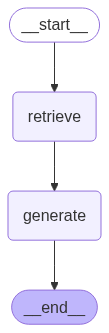

In [14]:
from langgraph.graph import START, StateGraph

# StateGraph 초기화
workflow = StateGraph(State)

# 검색(retrieve)과 생성(generate) 단계를 순차적으로 실행하도록 설정 (node 자동 추가)
workflow.add_sequence([retrieve, generate])

# 그래프의 시작점(START)을 'retrieve' 단계와 연결
workflow.add_edge(START, "retrieve")

# 그래프를 컴파일하여 최종 그래프 객체를 생성
app = workflow.compile()
app

In [15]:
# 그래프를 호출하여 사용자 질문에 대한 답변을 생성
result = app.invoke({"question": "Task Decomposition이 뭔가요? 한국어로 답해주세요."})

# 질문
#print(f'Question: {result["question"]}\n\n')

# 문서의 출처
#print(f'Context: {result["context"][0].metadata}\n\n')

# 생성된 답변(Answer)을 출력
print(f'Answer: {result["answer"]}')

Answer: Task Decomposition은 복잡한 작업을 여러 개의 작은 단계로 나누는 과정입니다. 이를 통해 작업을 더 쉽게 이해하고 수행할 수 있으며, 주로 언어모델이나 외부 도구를 활용하여 수행됩니다. 간단히 말해, 큰 목표를 달성하기 위한 세부 단계를 계획하는 방법입니다.


-----------------
**LangGraph**는 RAG 애플리케이션을 구축하는 데 반드시 필요하지는 않습니다. 실제로 개별 구성 요소를 사용하여 동일한 애플리케이션 로직을 구현할 수도 있습니다. 
그럼에도 LangGraph를 사용하는 이유는 복잡한 워크플로우 관리, 상태 관리 및 공유, 에이전트 간 협업 강화, 유연성과 확장성 때문 입니다.  

In [16]:
# Langgraph 없이 RAG 구현한 경우

prompt = hub.pull("rlm/rag-prompt")

question = "Task Decomposition이 뭔가요? 한국어로 답해주세요."

# 벡터 스토어에서 질문과 유사한 문서 검색
retrieved_docs = vector_store.similarity_search(question)

# 검색된 문서들의 내용을 하나의 문자열로 결합
docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)

# 검색된 문서(Context)와 질문을 프롬프트 템플릿에 전달하여 메시지 생성
message = prompt.invoke({"question": question, "context": docs_content}).to_messages()

# LLM(대형 언어 모델)을 호출하여 답변 생성
answer = llm.invoke(message)

# 생성된 답변 출력
print(answer.content)

Task Decomposition이란 큰 목표나 문제를 여러 개의 작은 단위 또는 하위 목표로 나누는 과정을 말합니다. 이렇게 나누면 복잡한 작업을 더 쉽게 해결할 수 있고, 단계별로 계획하거나 수행하기 쉬워집니다. 다양한 기법이나 도구를 통해 수행할 수 있으며, 사람이 직접 또는 인공지능 모델이 자동으로 수행할 수도 있습니다.


-----------------------------------------------

**LangGraph의 주요 장점은 다음과 같습니다:**  

- **다양한 호출 모드 지원:**  
  - 출력 토큰을 스트리밍하거나 각 단계의 결과를 스트리밍하려면 위의 로직을 다시 작성해야 합니다.  
  - LangGraph는 이러한 호출 모드를 기본적으로 지원합니다.  
<p></p>
- **자동 추적 및 배포 지원:**  
  - **LangSmith**를 통해 애플리케이션 단계를 자동으로 추적합니다.  
  - [**LangGraph 플랫폼**](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)을 통해 손쉽게 배포할 수 있습니다.  
<p></p>
- **지속성, 인간 개입(Human-in-the-loop) 지원:**  
  - LangGraph는 지속성(persistence) 및 인간 개입(human-in-the-loop) 기능을 기본적으로 지원합니다.  

<br>

**LangGraph**는 다양한 호출 모드(**동기(sync)**, **비동기(async)**, **스트리밍(streaming)**)를 지원합니다.  

###  **스트림 단계(Stream Steps) 반환**

In [17]:
# 그래프의 각 단계를 스트리밍 모드로 실행
# - stream_mode="updates": 각 단계가 완료될 때마다 업데이트를 반환
# - stream_mode="values": 최종 응답값만 반환
for step in app.stream(
    {"question": "Task Decomposition이 뭔가요? 한국어로 답해주세요."}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")    # 각 단계의 결과 출력

{'retrieve': {'context': [Document(id='ddb8fc9f-604f-458d-a156-68ff201d257c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to a